# Autoregressive Models

## Imports

In [1]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import date
import geopandas as gpd
from IPython.display import display, HTML
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utils import load_pkl, generate_times
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from metrics import *

from preprocessing import normalize

import tqdm as tqdm
from tqdm.autonotebook import tqdm
tqdm.pandas()

# Imports classes
from Baseline import *
from Regressor import *
from utils import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Loading Data

### Contour Iris

In [2]:
contour_iris = gpd.read_file(
    '../datasets/iris/iris.shp')

convert_to_int = ['dep', 'insee_com', 'iris', 'code_iris']
for col in convert_to_int:
    contour_iris[col] = contour_iris[col].astype(int)

contour_iris = contour_iris[['code_iris', 'geometry', 'dep']]
contour_iris.head();

### Stations and Dates

In [3]:
station_data = pd.read_csv("../datasets/station_to_iris.csv")
station_data.describe();

In [4]:
stations_mode = load_pkl("../datasets/stations_mode.pkl")
subway_stations = [k for k, v in stations_mode.items() if v == 3]
print("Number of Subway stations: {}".format(len(subway_stations)))

Number of Subway stations: 303


Subways stations with less than $80000$ validations per $3$ month. Note that this is before we normalize the data. In the article, they removed $3$ subways stations, assuming that it was closed for renovation work. We printed below the $4$ stations with smaller number of validations.

In [5]:
station_data[(station_data['id'].isin(subway_stations)) & (station_data['validations_count'] < 80000)];

In [6]:
dates = pd.date_range(start="2015-10-01", end="2015-12-31").date

### Discretized Matrix

In [7]:
matrix_6h = np.load("../datasets/6h_matrix.npy")
matrix_2h = np.load("../datasets/2h_matrix.npy")
matrix_15m = np.load("../datasets/15m_matrix.npy")

## Data Analysis and Preprocessing

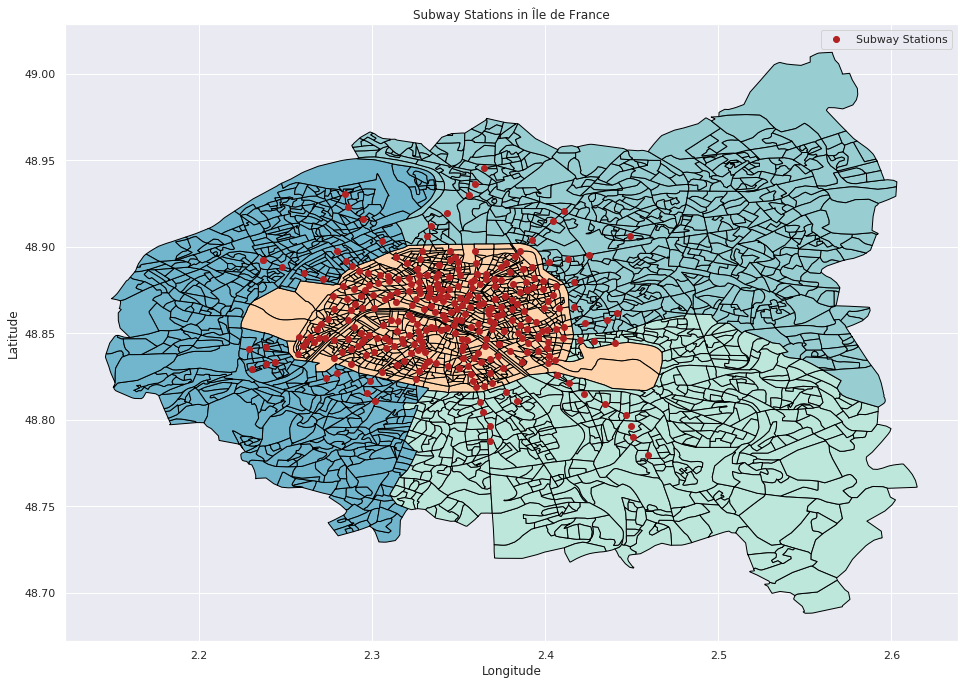

In [8]:
f, ax = plt.subplots(1, figsize=(16, 12))
ax = contour_iris[contour_iris['dep'].isin([75, 92, 93, 94])].plot(
    ax=ax, edgecolor='black', column='dep', cmap='icefire_r')
ax.scatter(station_data[station_data['id'].isin(subway_stations)]['x'],
           station_data[station_data['id'].isin(subway_stations)]['y'], color='firebrick', label='Subway Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Subway Stations in Île de France')
ax.legend()

plt.show();

### Min Max Normalization

Below we apply ``Min Max Normalization`` to data, with a scale range of $[0, 1]$.

In [9]:
data_matrix_6h = pd.Panel(normalize(matrix_6h), 
                         items=dates, 
                         major_axis=subway_stations, 
                         minor_axis=generate_times("6h")
                        )

data_matrix_2h = pd.Panel(normalize(matrix_2h), 
                         items=dates, 
                         major_axis=subway_stations, 
                         minor_axis=generate_times("2h")
                        )

data_matrix_15m_complete = pd.Panel(matrix_15m, 
                                    items=dates, 
                                    major_axis=subway_stations, 
                                    minor_axis=generate_times("15min")
                                   )

Delete the first $4$ hours, from $00.00.00$ to $04.00.00$ because it's useless, the number of validations in that range is mostly equal to 0.

In [10]:
del_hours = 5

In [11]:
data_matrix_15m = data_matrix_15m_complete.iloc[:, :, del_hours*4:]

In [12]:
data_matrix_15m.to_frame().head()

2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  \
major minor                                                                  
198   05:00:00         7.0        11.0         6.0        12.0        10.0   
      05:15:00        42.0        60.0        43.0        39.0        46.0   
      05:30:00        44.0        45.0        34.0        35.0        36.0   
      05:45:00        54.0        48.0        33.0        25.0        47.0   
      06:00:00        78.0        79.0        39.0        22.0        69.0   

                2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  \
major minor                                                                  
198   05:00:00         6.0         9.0        12.0         9.0        13.0   
      05:15:00        33.0        52.0        40.0        50.0        52.0   
      05:30:00        49.0        35.0        42.0        42.0        62.0   
      05:45:00        49.0        42.0        53.0        49.0        37.0   
      06:00:00        76.0        75.0        67.0        69.0        49.0   

                ...  2015-12-22  2015-12-23  2015-12-24  2015-12-25  \
major minor     ...                                                   
198   05:00:00  ...        11.0         9.0         7.0         1.0   
      05:15:00  ...        45.0        44.0        32.0        13.0   
      05:30:00  ...        41.0        38.0        23.0         2.0   
      05:45:00  ...        34.0        44.0        35.0         6.0   
      06:00:00  ...        72.0        65.0        31.0         4.0   

                2015-12-26  2015-12-27  2015-12-28  2015-12-29  2015-12-30  \
major minor                                                                  
198   05:00:00         5.0        10.0        12.0        10.0        10.0   
      05:15:00        36.0        24.0        34.0        40.0        26.0   
      05:30:00        18.0        22.0        45.0        31.0        30.0   
      05:45:00        30.0        25.0        32.0        42.0        34.0   
      06:00:00        46.0        24.0        60.0        70.0        75.0   

                2015-12-31  
major minor                 
198   05:00:00         5.0  
      05:15:00        40.0  
      05:30:00        21.0  
      05:45:00        43.0  
      06:00:00        54.0  

[5 rows x 92 columns]

In [13]:
dmatrix_mean_6h = data_matrix_6h.mean()
dmatrix_mean_2h = data_matrix_2h.mean()
dmatrix_mean_15m = data_matrix_15m.mean()

dtmatrix_mean_6h = dmatrix_mean_6h.transpose()
dtmatrix_mean_2h = dmatrix_mean_2h.transpose()
dtmatrix_mean_15m = dmatrix_mean_15m.transpose()

Again, this is another way to print the stations with a small number of validations.

In [14]:
data_matrix_15m.mean(axis=0)[data_matrix_15m.mean(axis=0).sum(axis=1) < 810];

In [15]:
dmatrix_mean_15m.head()
dtmatrix_mean_15m.head()

2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  \
05:00:00    2.643564    3.079208    2.458746    3.900990    2.973597   
05:15:00   19.864686   22.399340   14.254125   15.920792   20.858086   
05:30:00   31.471947   34.537954   20.429043   19.696370   32.630363   
05:45:00   31.874587   34.650165   19.184818   16.963696   32.729373   
06:00:00   40.541254   41.858086   22.465347   16.247525   39.689769   

          2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  ...  \
05:00:00    3.112211    3.293729    3.468647    3.254125    2.732673  ...   
05:15:00   21.353135   21.409241   21.976898   22.580858   14.488449  ...   
05:30:00   34.742574   34.587459   33.844884   34.650165   21.633663  ...   
05:45:00   33.726073   34.986799   35.514851   36.636964   21.346535  ...   
06:00:00   42.630363   42.940594   43.620462   40.709571   23.990099  ...   

          2015-12-22  2015-12-23  2015-12-24  2015-12-25  2015-12-26  \
05:00:00    2.696370    3.207921    2.920792    1.217822    2.019802   
05:15:00   20.884488   22.194719   20.630363    6.706271   10.858086   
05:30:00   33.270627   33.105611   31.198020    9.141914   15.617162   
05:45:00   32.234323   34.184818   31.392739    8.980198   14.277228   
06:00:00   40.828383   38.118812   34.425743   10.610561   17.316832   

          2015-12-27  2015-12-28  2015-12-29  2015-12-30  2015-12-31  
05:00:00    1.795380    2.805281    2.993399    3.112211    2.798680  
05:15:00    8.207921   20.369637   19.580858   19.729373   19.660066  
05:30:00   11.831683   29.382838   30.363036   29.349835   28.201320  
05:45:00   11.514851   26.808581   28.726073   28.009901   27.679868  
06:00:00   13.504950   30.168317   33.072607   30.247525   29.933993  

[5 rows x 92 columns]

05:00:00   05:15:00   05:30:00   05:45:00   06:00:00   06:15:00  \
2015-10-01  2.643564  19.864686  31.471947  31.874587  40.541254  48.481848   
2015-10-02  3.079208  22.399340  34.537954  34.650165  41.858086  50.056106   
2015-10-03  2.458746  14.254125  20.429043  19.184818  22.465347  24.531353   
2015-10-04  3.900990  15.920792  19.696370  16.963696  16.247525  17.610561   
2015-10-05  2.973597  20.858086  32.630363  32.729373  39.689769  52.072607   

             06:30:00   06:45:00    07:00:00    07:15:00  ...   21:30:00  \
2015-10-01  66.980198  83.894389  125.099010  184.508251  ...  70.927393   
2015-10-02  68.287129  85.666667  127.524752  172.877888  ...  78.590759   
2015-10-03  26.745875  28.478548   37.821782   48.861386  ...  82.211221   
2015-10-04  16.574257  16.574257   19.966997   24.042904  ...  43.570957   
2015-10-05  74.518152  87.603960  131.656766  177.980198  ...  61.039604   

             21:45:00   22:00:00   22:15:00   22:30:00   22:45:00   23:00:00  \
2015-10-01  66.881188  65.399340  60.584158  60.755776  64.207921  75.128713   
2015-10-02  73.495050  70.907591  65.983498  66.211221  62.917492  66.330033   
2015-10-03  77.181518  73.755776  72.805281  74.570957  76.264026  83.947195   
2015-10-04  43.818482  41.745875  37.462046  36.722772  37.283828  52.759076   
2015-10-05  52.346535  53.125413  46.059406  45.498350  41.036304  41.254125   

             23:15:00   23:30:00   23:45:00  
2015-10-01  64.590759  52.138614  43.818482  
2015-10-02  63.188119  57.755776  54.673267  
2015-10-03  80.049505  76.587459  72.772277  
2015-10-04  37.158416  31.211221  25.254125  
2015-10-05  35.336634  28.003300  22.801980  

[5 rows x 76 columns]

### With Outliers

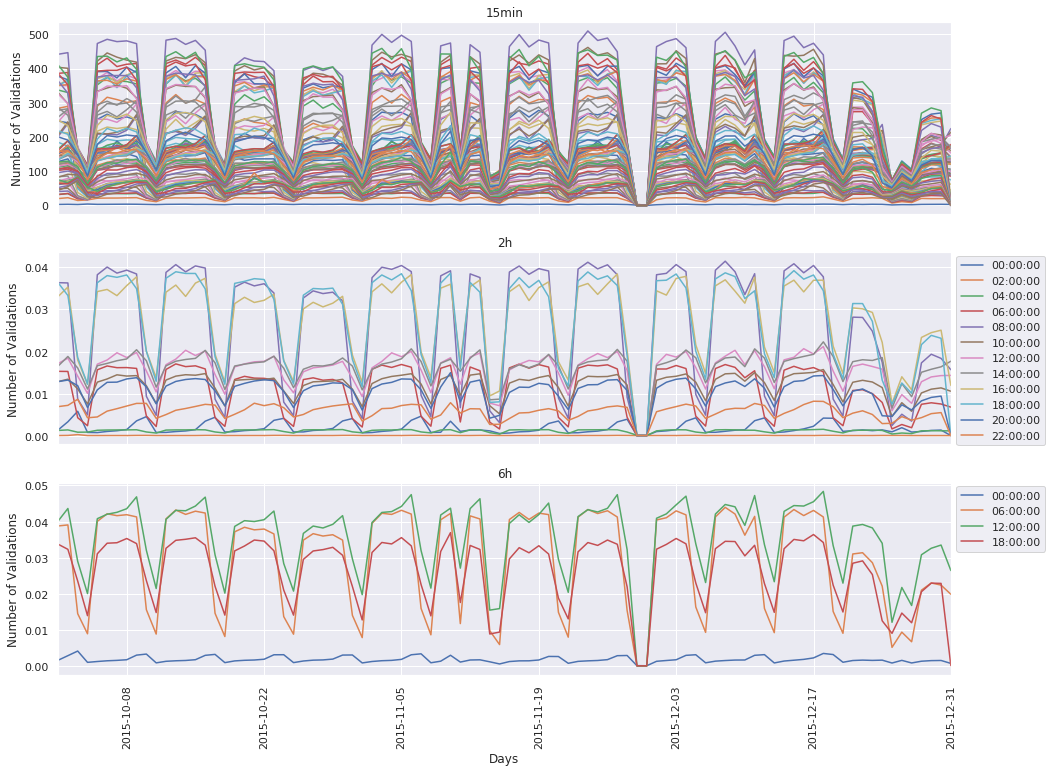

In [16]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dtmatrix_mean_15m.plot(ax=ax[0], legend=False)
ax1.set_xticklabels([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('15min')

ax2 = dtmatrix_mean_2h.plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Number of Validations')
ax2.set_title('2h')
ax2.legend(bbox_to_anchor=(1., 1.01))

ax3 = dtmatrix_mean_6h.plot(ax=ax[2])
ax3.set_xlabel('Days')
ax3.set_ylabel('Number of Validations')
ax3.set_title('6h')
ax3.legend(bbox_to_anchor=(1., 1.01))

plt.xticks(rotation=90)
plt.show();

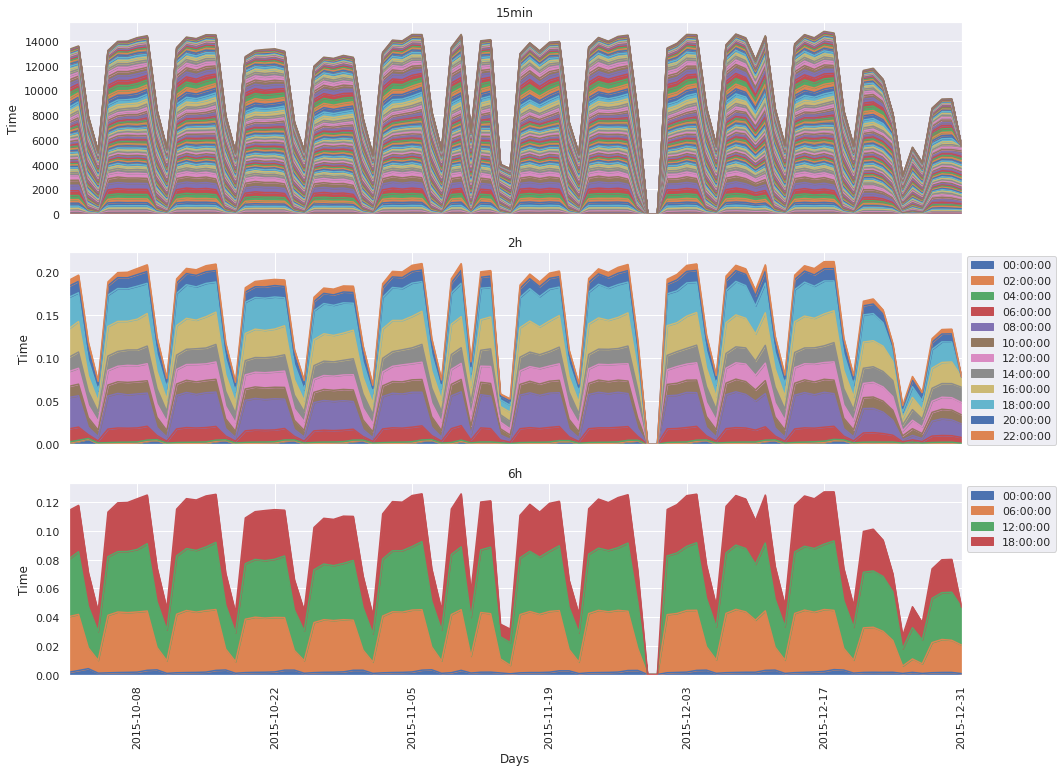

In [17]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dtmatrix_mean_15m.plot.area(ax=ax[0], legend=False)
ax1.set_xticklabels([])
ax1.set_ylabel('Time')
ax1.set_title('15min')

ax2 = dtmatrix_mean_2h.plot.area(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Time')
ax2.set_title('2h')
ax2.legend(bbox_to_anchor=(1., 1.01))

ax3 = dtmatrix_mean_6h.plot.area(ax=ax[2])
ax3.set_xlabel('Days')
ax3.set_ylabel('Time')
ax3.set_title('6h')
ax3.legend(bbox_to_anchor=(1., 1.01), loc=2)

plt.xticks(rotation=90)
plt.show();

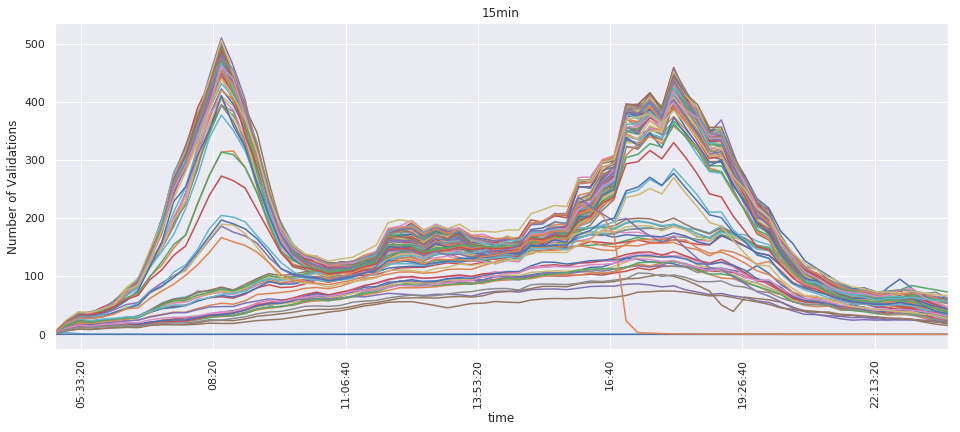

In [18]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])
dmatrix_mean_15m.plot(ax=ax, legend=False)
plt.ylabel('Number of Validations')
plt.title('15min')

plt.xticks(rotation=90)
plt.show();

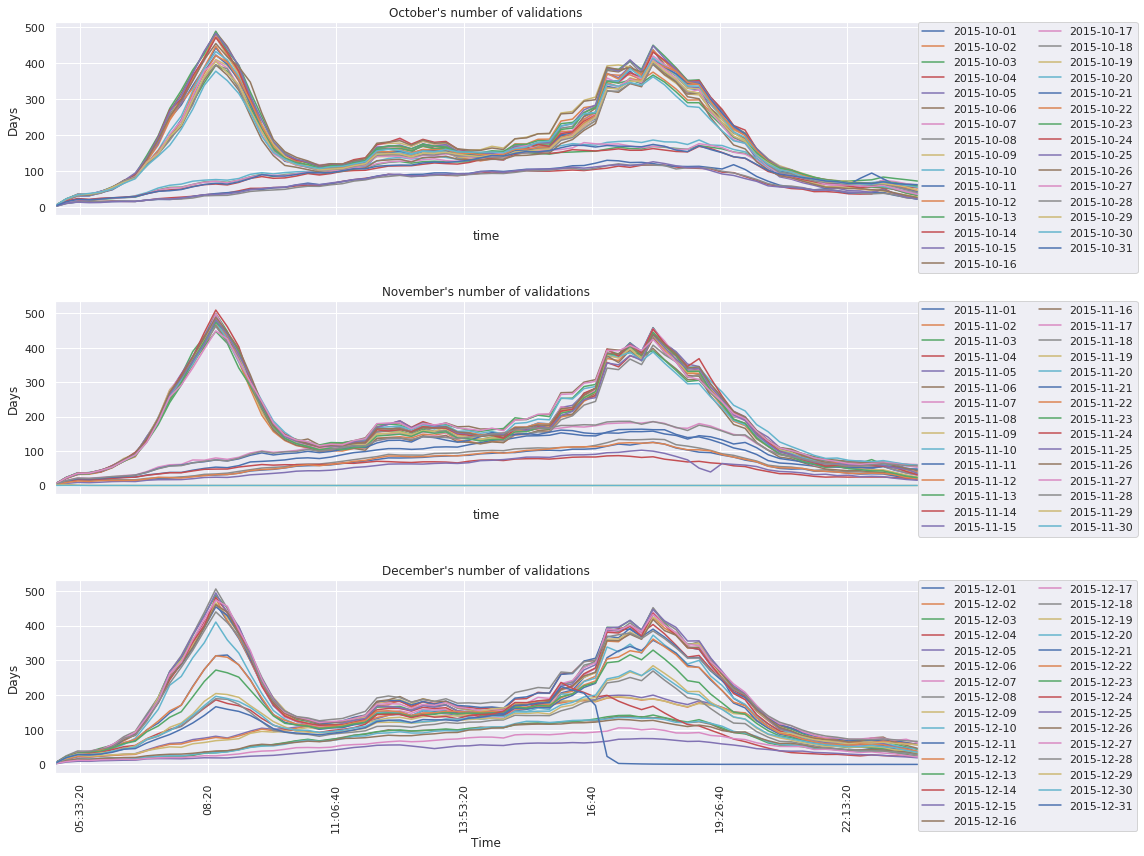

In [19]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dmatrix_mean_15m.iloc[:, :31].plot(ax=ax[0])
ax1.set_xticklabels([])
ax1.set_ylabel('Days')
ax1.set_title('October\'s number of validations')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)


ax2 = dmatrix_mean_15m.iloc[:, 31:61].plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Days')
ax2.set_title('November\'s number of validations')
ax2.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax3 = dmatrix_mean_15m.iloc[:, 61:].plot(ax=ax[2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Days')
ax3.set_title('December\'s number of validations')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

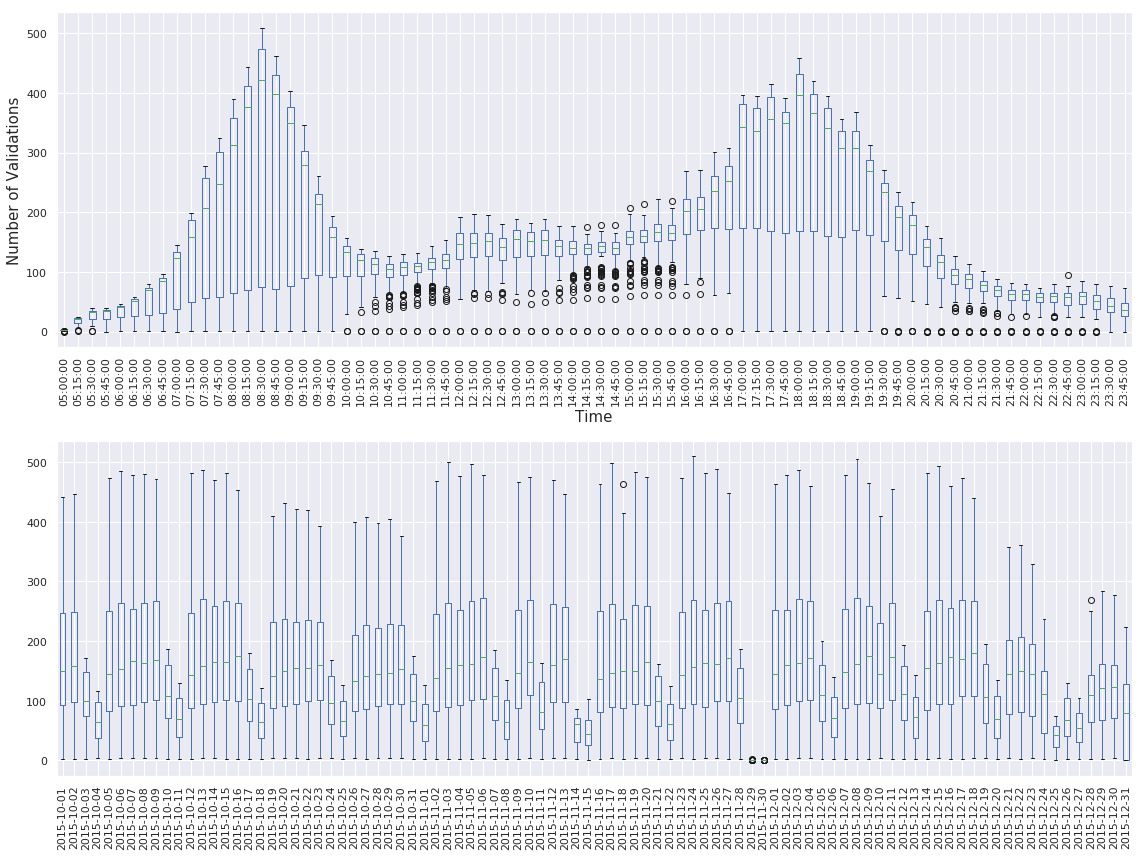

In [20]:
f, ax = plt.subplots(2, figsize=(16, 12))

ax1 = dtmatrix_mean_15m.boxplot(return_type='both', ax=ax[0])
ax[0].set_xlabel("Time", fontsize=15)
ax[0].set_ylabel("Number of Validations", fontsize=15)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax2 = dmatrix_mean_15m.boxplot(return_type='both', ax=ax[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

### Defining useful variables

In [21]:
from __init__ import *

In [22]:
wd_15m = data_matrix_15m.loc[dict_w.values()]
wdm_15m = wd_15m.mean()
wdmt_15m = wdm_15m.transpose()

wd_15mf = data_matrix_15m.loc[dict_wd_final.values()]
wdm_15mf = wd_15mf.mean()
wdmt_15mf = wdm_15mf.transpose()

### Without outliers

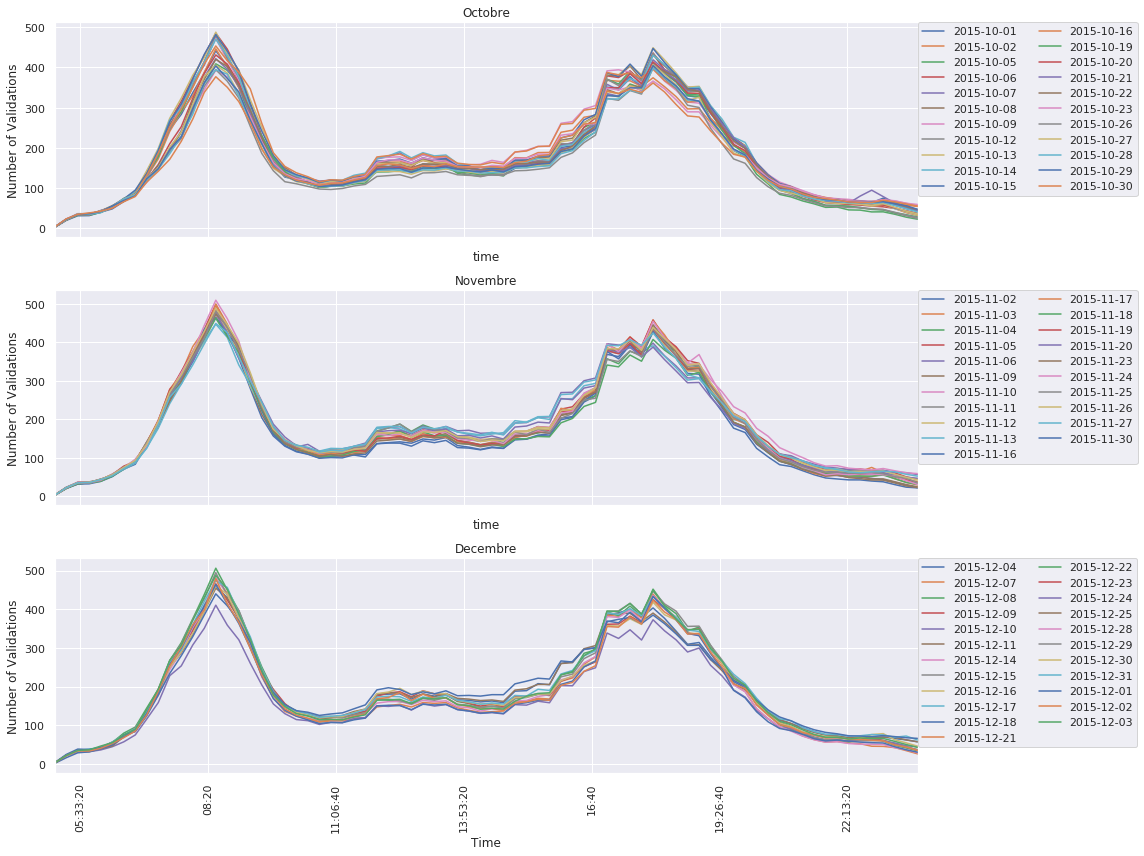

In [23]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = wdm_15m.loc[:, dict_wd_oct.values()].plot(ax=ax[0])
ax1.set_xticklabels([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('Octobre')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)


ax2 = wdm_15m.loc[:, dict_wd_nov.values()].plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Number of Validations')
ax2.set_title('Novembre')
ax2.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax3 = wdm_15m.loc[:, dict_wd_dec.values()].plot(ax=ax[2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Number of Validations')
ax3.set_title('Decembre')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

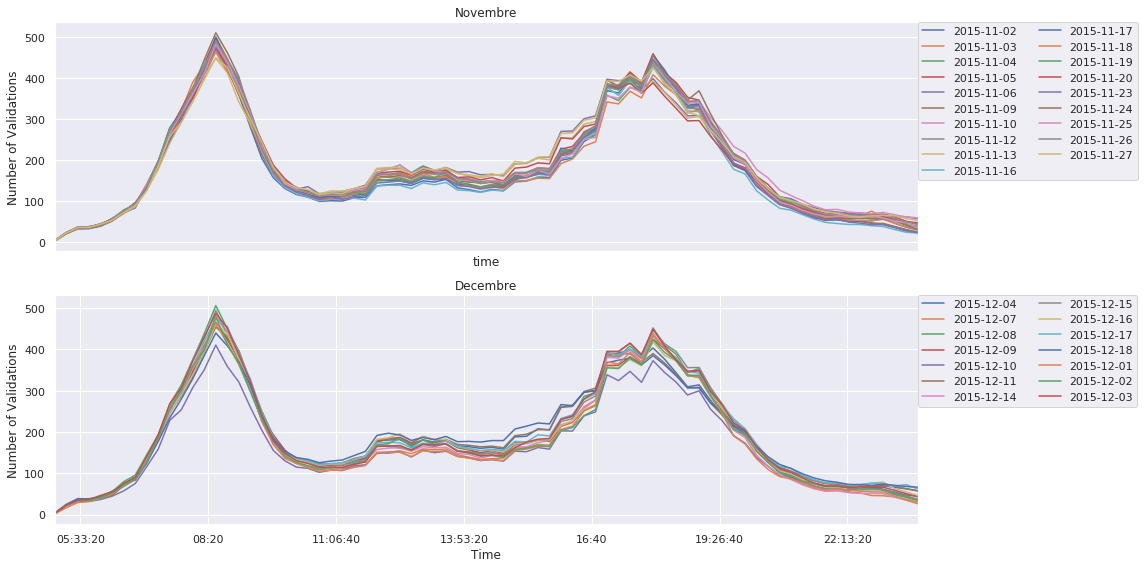

In [24]:
f, ax = plt.subplots(2, figsize=(16, 8))

ax1 = wdm_15mf.loc[:, dict_wd_novf.values()].plot(ax=ax[0])
ax1.set_xticks([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('Novembre')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax2 = wdm_15mf.loc[:, dict_wd_decf.values()].plot(ax=ax[1])
ax2.set_xlabel('Time')
ax2.set_ylabel('Number of Validations')
ax2.set_title('Decembre')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)
plt.tight_layout()

plt.show();

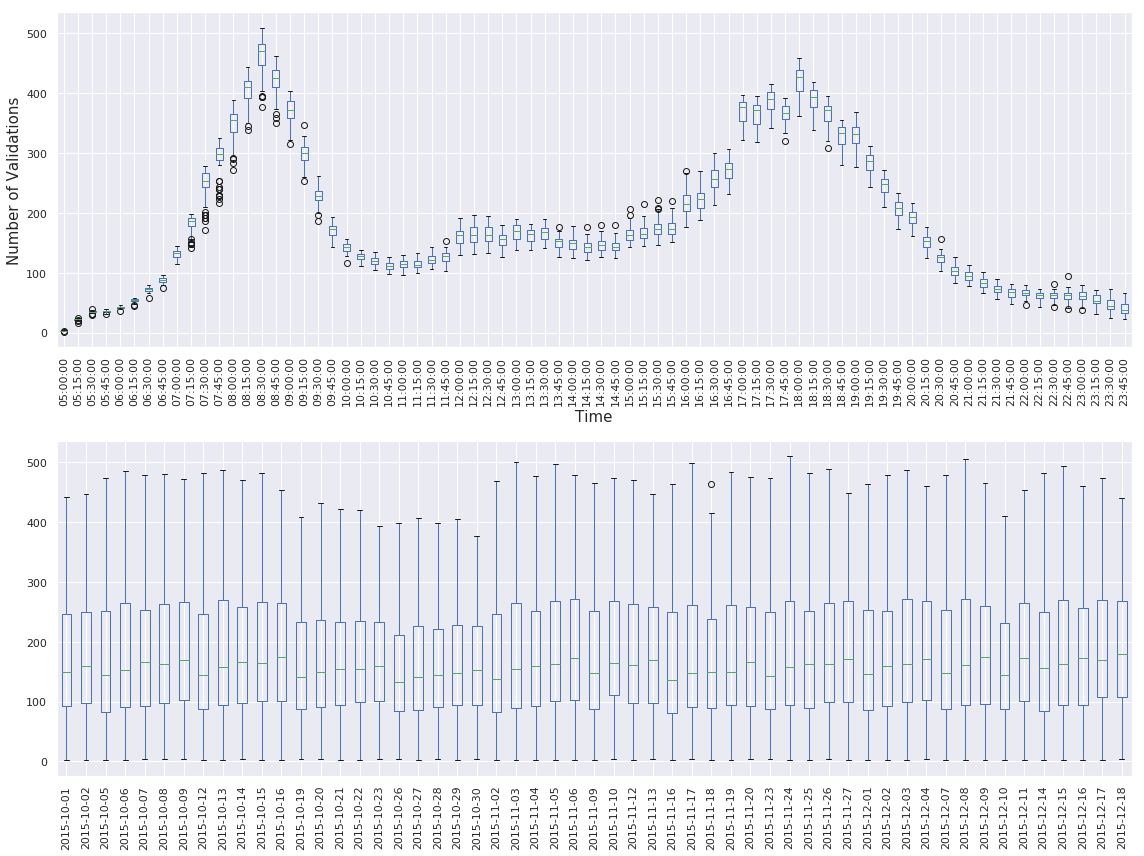

In [25]:
f, ax = plt.subplots(2, figsize=(16, 12))

ax1 = wdmt_15mf.boxplot(return_type='both', ax=ax[0])
ax[0].set_xlabel("Time", fontsize=15)
ax[0].set_ylabel("Number of Validations", fontsize=15)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax2 = wdm_15mf.boxplot(return_type='both', ax=ax[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

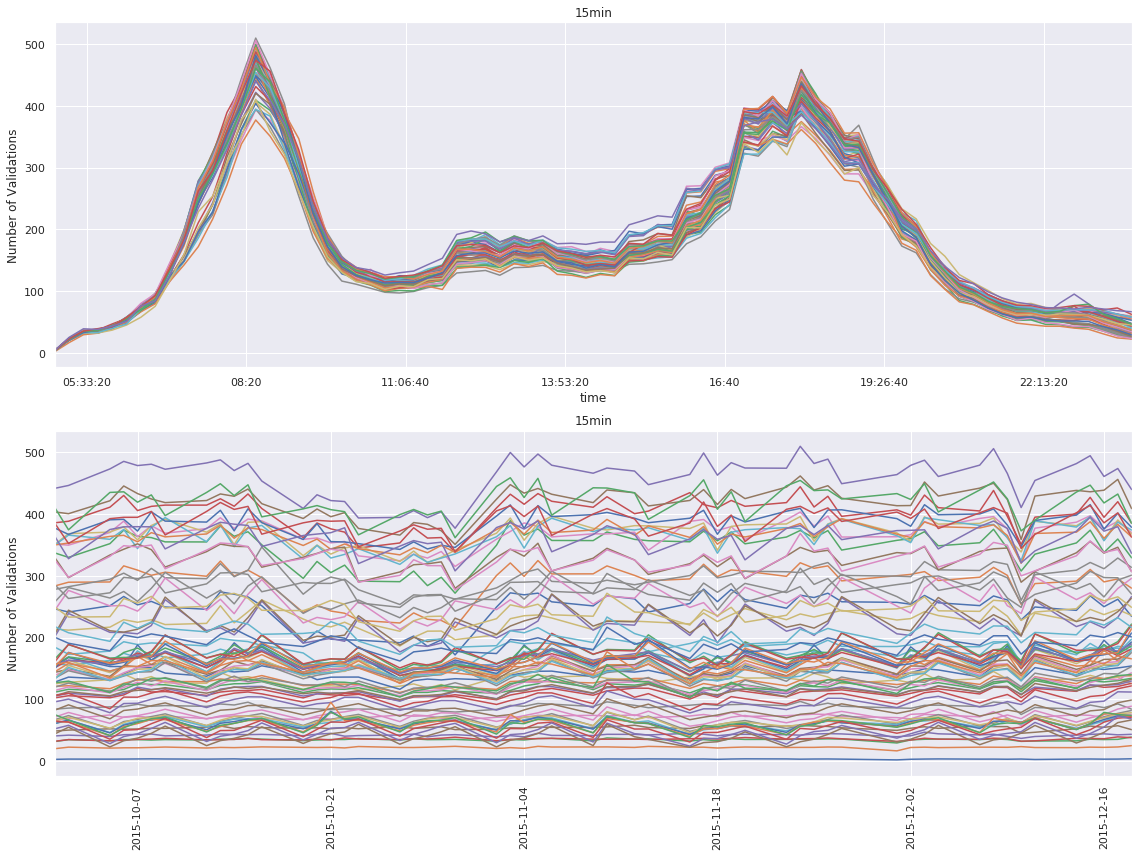

In [26]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

wdm_15mf.plot(ax=ax1, legend=False)
ax1.set_ylabel('Number of Validations'); ax1.set_title('15min')

ax2 = wdmt_15mf.plot(ax=ax2, legend=False)
ax2.set_ylabel('Number of Validations'); ax2.set_title('15min')

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

### Autocorrelation Plots

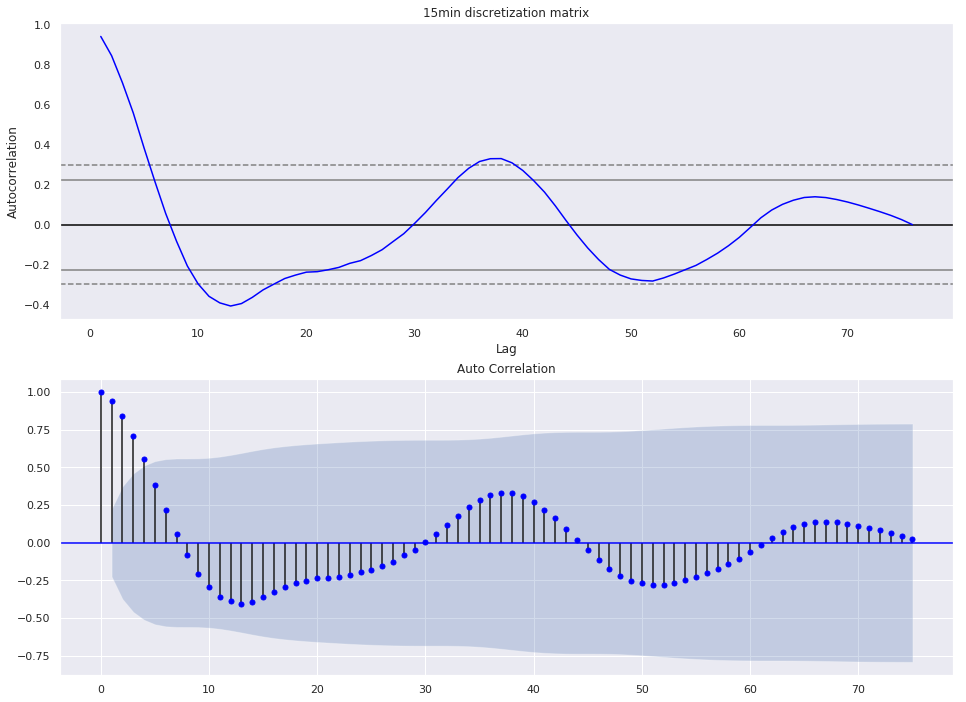

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

autocorrelation_plot(wdmt_15mf.mean(), ax=ax1, c='blue')
ax1.set_title('15min discretization matrix')

plot_acf(wdmt_15mf.mean(), ax=ax2, c='blue', title='Auto Correlation')

plt.show();

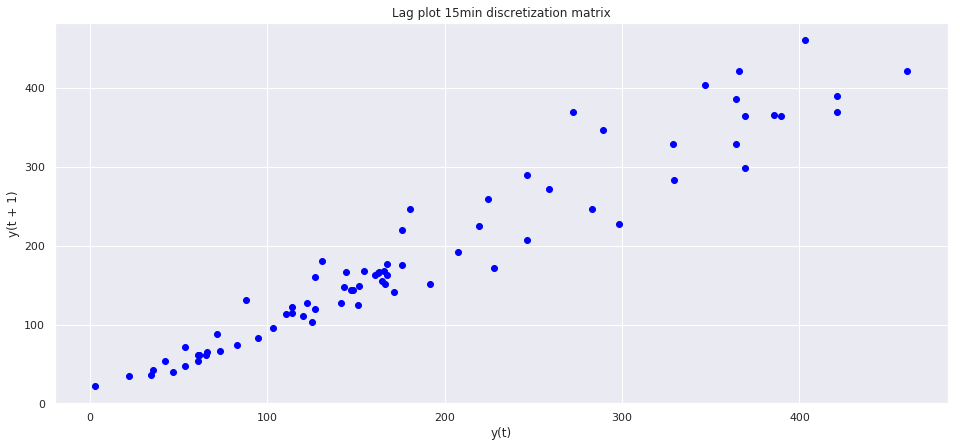

In [28]:
plt.figure(figsize=(16, 7))

lag_plot(wdmt_15mf.mean(), c='blue')
plt.title('Lag plot 15min discretization matrix')

# plot_pacf(wdmt_15mf.mean(), ax=ax[1], c='blue', title='Partial Auto Correlation')

plt.show();

### Splitting Data into Train and Test

In [29]:
dico = dict_wd
size = 45

In [30]:
X = data_matrix_15m.loc[dico.values()]
Xm = X.mean()
Xmt = Xm.transpose()

In [31]:
kw = list(dico.keys())
np.random.shuffle(kw)

vw = [dico[i] for i in kw]

In [32]:
ind_train = vw[:size]
ind_test = vw[size:]
X_train = X[ind_train]
X_test = X[ind_test]

In [33]:
X_train
X_test

<class 'pandas.core.panel.Panel'>
Dimensions: 45 (items) x 303 (major_axis) x 76 (minor_axis)
Items axis: 2015-10-20 to 2015-12-07
Major_axis axis: 198 to 60982
Minor_axis axis: 05:00:00 to 23:45:00

<class 'pandas.core.panel.Panel'>
Dimensions: 21 (items) x 303 (major_axis) x 76 (minor_axis)
Items axis: 2015-11-16 to 2015-10-12
Major_axis axis: 198 to 60982
Minor_axis axis: 05:00:00 to 23:45:00

## Models

### Baseline

In [34]:
def baseline_plot_results(levels):
    """
    
    """
    
    baseline_scores = []
    baseline_preds = []
    for level in levels:
        b = Baseline(level=level, first_ndays=5)
        b.fit(X_train)
        baseline_preds.append(b.predict(X_test))
        baseline_scores.append(b.score(X_test))
    
    df_baseline_scores = pd.DataFrame(np.array(baseline_scores).T,
                                 index=['R2', 'RMSE', 'MSE', 'MAE', 'MAPE', 'MPE'],
                                 columns=levels)
    display(HTML(df_baseline_scores.to_html()))
    pd.DataFrame(df_baseline_scores.loc['RMSE'].values.repeat(4).reshape(-1, 4).T,
                 columns=levels).plot(figsize=(16, 4), kind='area');
    
    return df_baseline_scores

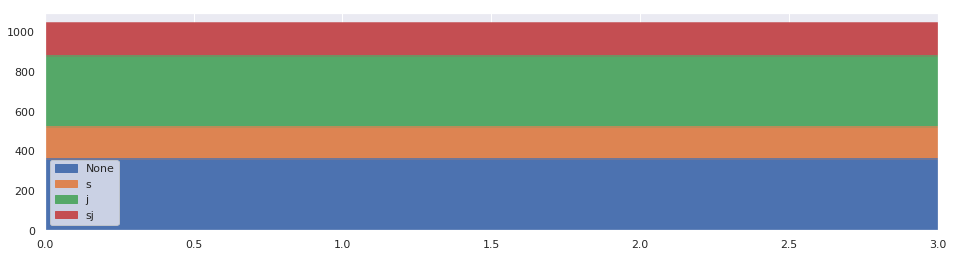

In [35]:
levels = ["None", "s", "j", "sj"]
df_baseline_scores = baseline_plot_results(levels)

In [36]:
from cost_functions import mse, mse_g

class myAR(Regressor):
    def __init__(self, order=4, level=None, loss=mse, loss_g=mse_g, max_iter=1000,
                 eps=0.01):
        """ Initialisation des paramètres du perceptron

        :param order: Taille de la fenêtre glissante
        :param loss: fonction de coût
        :param loss_g: gradient de la fonction coût
        :param max_iter: nombre maximum d'itération de la fonction coût
        :param eps: pas du gradient


        """

        self.order = order
        self.max_iter, self.eps = max_iter, eps
        self.loss, self.loss_g = loss, loss_g
        self.w = np.random.random(self.order)
                      
    
    @Regressor.datax_decorator
    def analytic_fit(self, datax):
        """ Finds the optimal weigths analytically 
        
        :param datax: contient tous les exemples du dataset
        :returns: void
        :rtype: None
        
        """
        
        self.X, self.y = datax
        A, B = self.X.T.dot(self.X), self.X.T.dot(self.y)
        self.w = np.linalg.solve(A, B).ravel()
        display(HTML(pd.DataFrame(self.w.reshape(1, -1), index=['Weights'], 
                                  columns=range(1, len(self.w)+1)).to_html()))
       

    def minibatch_fit(self, datax):
        """ Mini-Batch gradient descent Learning

        :param datax: contient tous les exemples du dataset
        
        """

        for _ in range(self.max_iter):
            for d in range(datax.shape[0]):
                for t in range(datax.shape[2] - self.order):
                    batchx = datax.iloc[d, :, t:t + self.order].values
                    batchy = datax.iloc[d, :, t + self.order].values
                    self.w -= (self.eps * self.loss_g(batchx, batchy, self.w))
                   

    def predict(self, datax):
        """ Predict labels

        :param datax: contient tous les exemples du dataset
        :returns: predicted labels
        :rtype: numpy array

        """

        y_pred = []
        for d in range(datax.shape[0]):
            y_pred.append([])
            for t in range(datax.shape[2] - self.order):
                batchx = datax.iloc[d, :, t:t + self.order].values
                y_pred[d].append(batchx.dot(self.w.T))

        return np.array(y_pred).transpose(0, 2, 1)

    def forecast_n(self, datax):
        """ Predict labels

        :param datax: contient tous les exemples du dataset
        :returns: predicted labels
        :rtype: numpy array

        """

        y_pred = []
        for d in range(datax.shape[0]):
            y_pred.append([])
            batchx = datax.iloc[d, :, 0:self.order].values
            for t in range(datax.shape[2] - self.order):
                next_y = batchx.dot(self.w.T)
                y_pred[d].append(next_y)
                batchx = np.hstack(
                    (batchx[:, 1:], np.array(next_y).reshape(-1, 1)))

        return np.array(y_pred).transpose(0, 2, 1)
    
    def transform_batchx(self, batchx, tplus):
        """
        """
        if tplus == 1:
            return batchx
        
        for _ in range(tplus-1):
            next_y = batchx.dot(self.w.T)
            if batchx.ndim == 2:
                batchx = np.hstack((batchx[:, 1:], 
                                    np.array(next_y).reshape(-1, 1)))
            elif batchx.ndim == 1:
                batchx = np.hstack((batchx[1:], next_y))
                
        return batchx
    
    
    def forecast(self, datax, tplus=None):
        """ Predict labels

        :param datax: contient tous les exemples du dataset
        :param tplus: if t equal to 2, means predicting what happened at t+2
        :returns: predicted labels
        :rtype: numpy array
        
        """
                
        if tplus == None or tplus > self.order:
            return self.forecast_n(datax)
        else:
            y_pred = []
            batch_ind = self.order - tplus
            
            if datax.ndim == 3:
                for d in range(datax.shape[0]):
                    y_pred.append([])
                    # Take the first batch
                    batchx = datax.iloc[d, :, 0:self.order].values
                    # Predict till we finish the first round of tplus
                    for _ in range(tplus):
                        next_y = batchx.dot(self.w.T)
                        y_pred[d].append(next_y)
                        batchx = np.hstack((batchx[:, 1:], 
                                            np.array(next_y).reshape(-1, 1)))
                        
                    # After the first round of tplus, we have to replace some
                    # predicted values by the real ones and simultaneously 
                    # replace the following columns by t+1,..., tplus
                    for t in range(1, datax.shape[2] - self.order - tplus + 1): 
                        batchx = self.transform_batchx(
                            datax.iloc[d, :, t:self.order+t].values, tplus)
                        next_y = batchx.dot(self.w.T)
                        # next_y = np.where(next_y < 0, 0, next_y)
                        y_pred[d].append(next_y)
                        
                        
            elif datax.ndim == 2:
                # TODO
                pass
            elif datax.ndim == 1:
                batchx = datax.iloc[0:self.order].values
                
                for _ in range(tplus):
                    next_y = batchx.dot(self.w.T)
                    y_pred.append(next_y)
                    batchx = np.hstack((batchx[1:], next_y))
                        
                for t in range(1, datax.shape[0] - self.order - tplus + 1):
                    batchx = self.transform_batchx(
                            datax.iloc[t:self.order+t].values, tplus)
                    next_y = batchx.dot(self.w.T)
                    # if next_y < 0: next_y = 0
                    y_pred.append(next_y)
                    
                return np.array(y_pred)
            else:
                raise ValueError("Untreated datax number of dimensions")
                                        
        return np.array(y_pred).transpose(0, 2, 1)
    

In [37]:
class theAR(Baseline):
    def __init__(self, level=None, first_ndays=7, **kwargs):
        """
        
        """
        
        super().__init__(level, first_ndays)
        self.kwargs = kwargs
        
    def fit(self, datax):
        """
        
        """
        
        if self.level is None:
            self.model = myAR(**self.kwargs)
            self.model.analytic_fit(datax)
        elif self.level.lower() == "s":
            self.models = []            
            for s in range(datax.shape[1]):
                Xs = datax.iloc[:, s].T
                self.models.append(myAR(**self.kwargs))
                self.models[s].analytic_fit(Xs)
        elif self.level.lower() == "j":
            # TODO
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean().mean(axis=1))                
        elif self.level.lower() == "sj":
            # TODO
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean(axis=0))
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
    
    
    def predict(self, datax, tplus=None):
        """
        
        """
        
        def predict_per_station(x, tplus):
            pred_s = []
            for s in range(x.shape[0]):
                pred_s.append(self.models[s].forecast(x.iloc[s], tplus))
            return np.array(pred_s)
        
        if self.level is None:
            return self.model.forecast(datax, tplus)
        elif self.level.lower() == "s":
            return datax.apply(
                lambda x: predict_per_station(x, tplus), axis=(1, 2))
        elif self.level.lower() == "j":
            # TODO
            pass
        elif self.level.lower() == "sj":
            # TODO
            pass
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
    
    
    def score(self, datax, tplus=None):
        """
        
        """
        
        X_pred = self.predict(datax, tplus)
       
        try:
            df_X = datax.iloc[:, :, self.model.order:]
            return super().metrics_score(df_X, X_pred)
        except:
            df_X = datax.iloc[:, :, self.models[0].order:]            
            return super().metrics_score(df_X, X_pred.values)

    

In [38]:
def ar_plot_results(level, order, limit_t):
    """
    
    """
    
    ar_scores = []
    ar_preds = []
    ar = theAR(level=level, order=order)
    print("Fitting...")
    ar.fit(X_train)
    print("Predicting...")
    for t in tqdm(range(1, limit_t+1)):
        ar_preds.append(ar.predict(X_test, t))
        ar_scores.append(ar.score(X_test, t))
        
    print("Scoring...")
    display(HTML((pd.DataFrame(np.array(ar_scores).T, 
                               index=['R2', 'RMSE', 'MSE', 'MAE', 'MAPE', 'MPE'], 
                               columns=list(map(
                                   lambda x: "t+"+str(x),
                                   range(1, len(ar_scores)+1))))).to_html()))
    return ar_scores, ar_preds

def plot_qualitative_analysis(*args):
    """
    
    """
    
    fig, ax = plt.subplots(limit_t+1, figsize=(16, limit_t*4))

    wd_testorder_15m = args[1].iloc[:, :, order:]
    wdm_testorder_15m = wd_testorder_15m.mean()

    wdm_testorder_15m.plot(ax=ax[0])
    ax[0].set_ylabel('Number of Validations')
    ax[0].set_title('Test')
    ax[0].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
               borderaxespad=0.)

    for i in range(1, limit_t+1):
        pred_t = create_panel_pred(*args).mean()
        pred_t.plot(ax=ax[i])
        ax[i].set_ylabel('Number of Validations')
        ax[i].set_title("Predict t+{}".format(i))
        ax[i].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
                     borderaxespad=0.)

    plt.tight_layout()
    plt.show();

### Order=16, T=12

#### One AR for all

In [53]:
order = 8
limit_t = 4

In [54]:
%%time
ar_scores, ar_preds = ar_plot_results(None, order, limit_t)

Fitting...


Predicting...


Scoring...


CPU times: user 4.28 s, sys: 556 ms, total: 4.84 s
Wall time: 4.38 s


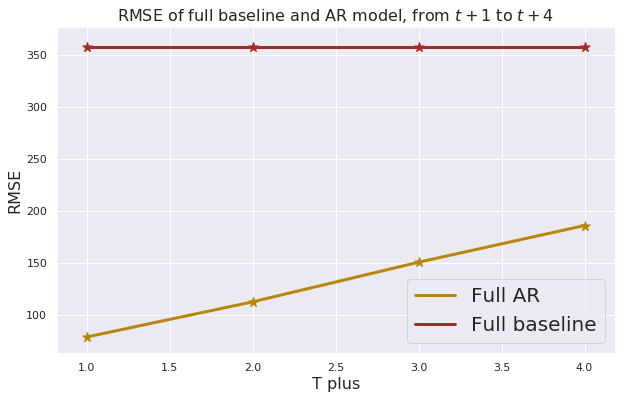

In [55]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_prop_cycle(color=['darkgoldenrod', 'brown'])
x = range(1, limit_t+1)
baseline_score = df_baseline_scores.loc['RMSE', 'None'].repeat(limit_t).reshape(-1, limit_t).T
model_score = np.array(ar_scores).T[1]

ax = plt.plot(x, model_score, linewidth=3, label="Full AR")
ax = plt.scatter(x, model_score, marker='*', s=100)
ax = plt.plot(x, baseline_score, linewidth=3, label="Full baseline")
ax = plt.scatter(x, baseline_score, marker='*', s=100)

plt.legend(prop={'size': 20})
plt.title("RMSE of full baseline and AR model, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

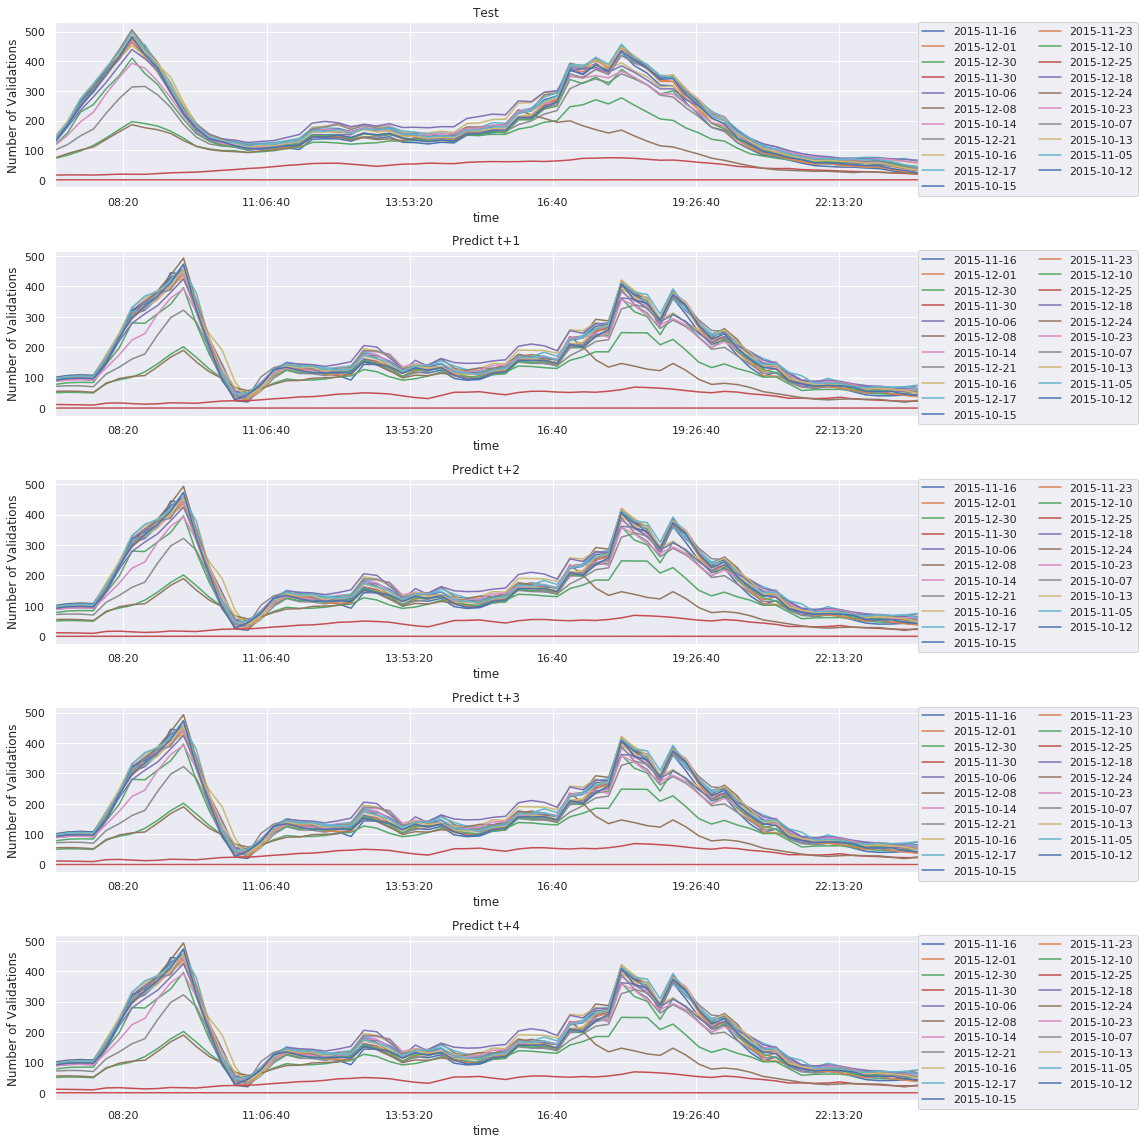

In [56]:
plot_qualitative_analysis(ar_preds, X_test, limit_t, order, subway_stations, del_hours)

#### AR per station

In [57]:
order = 8
limit_t = 4

In [58]:
%%time
ar_scores_s, ar_preds_s = ar_plot_results("s", order, limit_t)

Fitting...


Predicting...


Scoring...


CPU times: user 4min 39s, sys: 40.7 s, total: 5min 20s
Wall time: 4min 25s


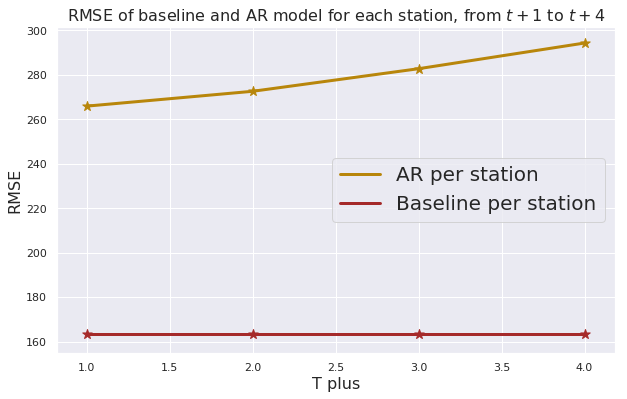

In [59]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_prop_cycle(color=['darkgoldenrod', 'brown'])
x = range(1, limit_t+1)
baseline_score = df_baseline_scores.loc['RMSE', 's'].repeat(limit_t).reshape(-1, limit_t).T
model_score = np.array(ar_scores_s).T[1]

ax = plt.plot(x, model_score, linewidth=3, label="AR per station")
ax = plt.scatter(x, model_score, marker='*', s=100)
ax = plt.plot(x, baseline_score, linewidth=3, label="Baseline per station")
ax = plt.scatter(x, baseline_score, marker='*', s=100)

plt.legend(prop={'size': 20})
plt.title("RMSE of baseline and AR model for each station, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

#### Compute and Compare 

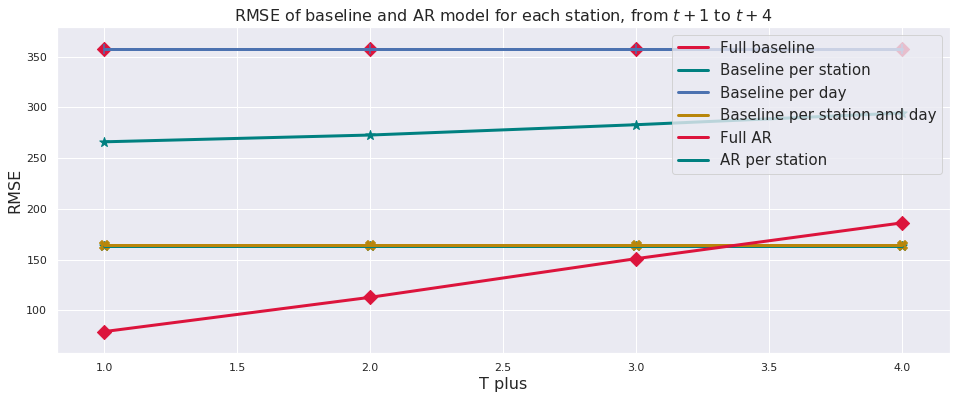

In [60]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.set_prop_cycle(color=['crimson', 'teal', 'b', 'darkgoldenrod'])
x = range(1, limit_t+1)
baseline_scores = df_baseline_scores.loc['RMSE'].values.repeat(limit_t).reshape(-1, limit_t).T
model_scores = np.vstack((np.array(ar_scores).T[1], np.array(ar_scores_s).T[1])).T
baselineObjects = plt.plot(x, baseline_scores, linewidth=3)
labels = ["Full baseline", "Baseline per station", "Baseline per day",
                    "Baseline per station and day", "Full AR", "AR per station"]
arlineObjects = plt.plot(x, model_scores, linewidth=3)

for i, m in zip(range(4), ['D', '*', '|', 'X']):
    ax = plt.scatter(x, baseline_scores[:, i], marker=m, s=100)

for i, m in zip(range(2), ['D', '*']):
    ax = plt.scatter(x, model_scores[:, i], marker=m, s=100)
    
plt.legend(baselineObjects+arlineObjects, labels, prop={'size': 15})
plt.title("RMSE of baseline and AR model for each station, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

### Order=4, T=4

#### One AR for all

In [ ]:
order = 4
limit_t = 4

In [ ]:
%%time
ar_scores, ar_preds = ar_plot_results(None, order, limit_t)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_prop_cycle(color=['darkgoldenrod', 'brown'])
x = range(1, limit_t+1)
baseline_score = df_baseline_scores.loc['RMSE', 'None'].repeat(limit_t).reshape(-1, limit_t).T
model_score = np.array(ar_scores).T[1]

ax = plt.plot(x, model_score, linewidth=3, label="Full AR")
ax = plt.scatter(x, model_score, marker='*', s=100)
ax = plt.plot(x, baseline_score, linewidth=3, label="Full baseline")
ax = plt.scatter(x, baseline_score, marker='*', s=100)

plt.legend(prop={'size': 20})
plt.title("RMSE of full baseline and AR model, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

#### AR per station

In [ ]:
order = 4
limit_t = 4

In [ ]:
%%time
ar_scores_s, ar_preds_s = ar_plot_results("s", order, limit_t)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_prop_cycle(color=['darkgoldenrod', 'brown'])
x = range(1, limit_t+1)
baseline_score = df_baseline_scores.loc['RMSE', 's'].repeat(limit_t).reshape(-1, limit_t).T
model_score = np.array(ar_scores_s).T[1]

ax = plt.plot(x, model_score, linewidth=3, label="AR per station")
ax = plt.scatter(x, model_score, marker='*', s=100)
ax = plt.plot(x, baseline_score, linewidth=3, label="Baseline per station")
ax = plt.scatter(x, baseline_score, marker='*', s=100)

plt.legend(prop={'size': 20})
plt.title("RMSE of baseline and AR model for each station, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

#### Compute and Compare 

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.set_prop_cycle(color=['crimson', 'teal', 'b', 'darkgoldenrod'])
x = range(1, limit_t+1)
baseline_scores = df_baseline_scores.loc['RMSE'].values.repeat(limit_t).reshape(-1, limit_t).T
model_scores = np.vstack((np.array(ar_scores).T[1], np.array(ar_scores_s).T[1])).T
baselineObjects = plt.plot(x, baseline_scores, linewidth=3)
labels = ["Full baseline", "Baseline per station", "Baseline per day",
                    "Baseline per station and day", "Full AR", "AR per station"]
arlineObjects = plt.plot(x, model_scores, linewidth=3)
for i, m in zip(range(4), ['D', '*', '|', 'X']):
    ax = plt.scatter(x, baseline_scores[:, i], marker=m, s=100)

for i, m in zip(range(2), ['D', '*']):
    ax = plt.scatter(x, model_scores[:, i], marker=m, s=100)
plt.legend(baselineObjects+arlineObjects, labels, prop={'size': 15})
plt.title("RMSE of baseline and AR model for each station, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

## Brouillon 